# Importing relevant packages

In [1]:
import numpy as np
import pandas as pd

# Charting library
import matplotlib.pyplot as plt

# nltk is used to help preprocess our data
import nltk
from nltk.stem import WordNetLemmatizer

# Gensim contain our topic model
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

In [2]:
# nltk.download()
# Running this command will open a new window in the background. We only want to download worknet and close the window afterwards
# Uncomment and run the first line if there is an error that wordnet cannot be found

# Data Cleaning

In [3]:
data = pd.read_csv("data.csv", encoding = "latin")

In [4]:
data.head()

,title,reviewTxt,reviewTime,productID_index,reviewID_index,reviewerID_index
0,Nike Flight headphones.,"the unit right out of the box is faulty, does ...","01 04, 2013",1,1,1
1,Good outdoor usage headphones,i go through a lot of headphones and these are...,"27 12, 2012",1,2,2
2,Sound very much above their price.,listening to them right now. very impressed. i...,"16 01, 2016",2,3,3
3,Not good at all,"not good at all, no extra bass. the difference...","16 05, 2015",2,4,4
4,Very nice.,the more i listen the more i listen like them....,"19 03, 2015",2,5,5


## Removing irrelevant columns

In [5]:
data = data[[col for col in data.columns if col not in ['reviewTime','reviewerID_index']]]
data.head()

,title,reviewTxt,productID_index,reviewID_index
0,Nike Flight headphones.,"the unit right out of the box is faulty, does ...",1,1
1,Good outdoor usage headphones,i go through a lot of headphones and these are...,1,2
2,Sound very much above their price.,listening to them right now. very impressed. i...,2,3
3,Not good at all,"not good at all, no extra bass. the difference...",2,4
4,Very nice.,the more i listen the more i listen like them....,2,5


## Removing duplicated reviews

In [6]:
print("Number of duplicated reviews: " , data.duplicated(['reviewID_index']).sum())
print("Number of duplicated rows: " , data.duplicated().sum())

Number of duplicated reviews:  146004
Number of duplicated rows:  1481


In [7]:
data = data.drop_duplicates(['reviewID_index'],keep = 'first')
print("Number of duplicated reviews: " , data.duplicated(['reviewID_index']).sum())
print("Number of duplicated rows: " , data.duplicated().sum())

Number of duplicated reviews:  0
Number of duplicated rows:  0


## Removing empty cells

In [8]:
# Checking for NA
data.isna().sum()

title               2
reviewTxt          21
productID_index     0
reviewID_index      0
dtype: int64

In [9]:
# Removing NA
data = data[pd.notnull(data['title'])]
data = data[pd.notnull(data['reviewTxt'])]

In [10]:
# Verify that there is no more NA
data.isna().sum()

title              0
reviewTxt          0
productID_index    0
reviewID_index     0
dtype: int64

## Combining title and reviewTxt

In [11]:
data['title'] = data['title'] + ' ' + data['reviewTxt']
data = data[[col for col in data.columns if col != 'reviewTxt']]
# We can remove reviewID_index since there are no more duplicates. We only want the productID and their reviews
data = data[[col for col in data.columns if col != 'reviewID_index']]
data.rename(columns={'title':'reviewTxt'}, inplace=True)
data.head()

,reviewTxt,productID_index
0,Nike Flight headphones. the unit right out of ...,1
1,Good outdoor usage headphones i go through a l...,1
2,Sound very much above their price. listening t...,2
3,"Not good at all not good at all, no extra bass...",2
4,Very nice. the more i listen the more i listen...,2


## Collating all reviews of the same product

In [12]:
data = data.groupby('productID_index')['reviewTxt'].apply(lambda x: " ".join(x)).to_frame().reset_index()
data.head(10)

,productID_index,reviewTxt
0,1,Nike Flight headphones. the unit right out of ...
1,2,Sound very much above their price. listening t...
2,3,For the Money it is HARD to beat! i own very g...
3,4,GREAT!!!!! SOUND!!!! GREAT PRICE!!!! these jvc...
4,5,warning language sounds ok but the auto voice ...
5,6,"love these ear buds still,love these ear buds,..."
6,7,Very Good product. I had TV ears that was very...
7,8,These earphones are OKAY. And only so. They .....
8,9,"they sounded terrible, they were worse then th..."
9,10,Fantastic earphones these earphones are fantas...


# Data pre-processing

In [13]:
# lemmatizing
def lemmatize(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    return wordnet_lemmatizer.lemmatize(text)

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize(token))
            
    return result

In [14]:
# Process the review of every row
data['reviewTxt'] = data['reviewTxt'].apply(preprocess)

If the above cell produces an error, please run the 2nd cell in this notebook (nltk.download())

# Determining number of topics

In [15]:
reviews = data['reviewTxt']
dictionary = gensim.corpora.Dictionary(reviews) # Associate words to a numeric ID
bow_corpus = [dictionary.doc2bow(doc) for doc in reviews] # Transform the collection of texts to a numerical form

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# Warning: This cell takes a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=bow_corpus, texts=reviews, start=10, limit=20, step=1)

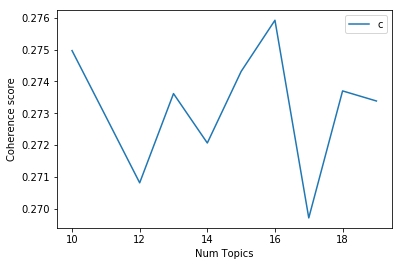

In [18]:
# Show graph
limit=20; start=10; step=1;
x = range(start, limit, step)

plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Building LDA model

In [29]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 16, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

# Topic Distribution over word (16 topics, 10 words)

In [30]:
for idx in range(16):
    # Print the first 16 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))

Topic #0: 0.031*"sound" + 0.023*"headphone" + 0.020*"great" + 0.019*"good" + 0.016*"ear" + 0.014*"quality" + 0.012*"like" + 0.012*"price" + 0.011*"head" + 0.011*"bud"
Topic #1: 0.042*"tip" + 0.020*"foam" + 0.018*"sound" + 0.014*"great" + 0.013*"comply" + 0.011*"ear" + 0.011*"headphone" + 0.011*"comfortable" + 0.010*"better" + 0.010*"good"
Topic #2: 0.008*"sound" + 0.007*"great" + 0.007*"good" + 0.007*"headphone" + 0.004*"pair" + 0.004*"price" + 0.003*"work" + 0.003*"quality" + 0.003*"earbuds" + 0.003*"product"
Topic #3: 0.025*"headphone" + 0.024*"sound" + 0.021*"great" + 0.016*"good" + 0.013*"quality" + 0.011*"work" + 0.009*"bluetooth" + 0.009*"pair" + 0.008*"time" + 0.008*"star"
Topic #4: 0.034*"sound" + 0.017*"headphone" + 0.015*"bass" + 0.013*"good" + 0.012*"quality" + 0.011*"great" + 0.009*"earphone" + 0.009*"like" + 0.008*"music" + 0.008*"earbuds"
Topic #5: 0.031*"sound" + 0.020*"good" + 0.019*"great" + 0.019*"headphone" + 0.016*"bud" + 0.016*"earbuds" + 0.015*"quality" + 0.013*"p

In [41]:
# Displaying topics in a table (a better visualisation)
word_dict = {};
for i in range(16):
    words = lda_model.show_topic(i, topn = 10)
    word_dict['Topic # ' + '{:02d}'.format(i)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15
0,sound,tip,sound,headphone,sound,sound,sound,sound,headphone,sound,noise,headphone,sound,sound,sound,star
1,headphone,foam,great,sound,headphone,good,great,headphone,sound,great,headphone,sound,great,great,headphone,sound
2,great,sound,good,great,bass,great,headphone,good,bose,headphone,sound,great,earbuds,headphone,great,great
3,good,great,headphone,good,good,headphone,good,quality,great,good,bose,good,headphone,good,good,headphone
4,ear,comply,pair,quality,quality,bud,quality,noise,quality,price,great,work,good,quality,ear,quality
5,quality,ear,price,work,great,earbuds,bluetooth,great,pair,quality,good,quality,quality,earbuds,quality,work
6,like,headphone,work,bluetooth,earphone,quality,work,work,good,earbuds,work,running,work,price,price,good
7,price,comfortable,quality,pair,like,pair,phone,bud,comfortable,pair,cancelling,ear,ear,pair,stay,product
8,head,better,earbuds,time,music,cord,star,like,like,star,quality,product,bud,star,pair,like
9,bud,good,product,star,earbuds,price,pair,star,ear,ear,music,pair,case,love,work,pair


# Finding the dominant topic for each product

In [32]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        ##
        ##
        ##
        # Add the row code here
        ##
        ##
        ##
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
#                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [33]:
# Warning: This cell takes quite some time to run
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=reviews)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'reviewTxt']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,reviewTxt
0,0,11.0,0.4926,"[nike, flight, headphone, unit, right, faulty,..."
1,1,4.0,0.9733,"[sound, price, listening, right, impressed, ow..."
2,2,4.0,0.4859,"[money, hard, beat, good, regular, headphone, ..."
3,3,13.0,0.3297,"[great, sound, great, price, earphone, work, n..."
4,4,4.0,0.4772,"[warning, language, sound, auto, voice, englis..."
5,5,9.0,0.5067,"[love, bud, love, bud, inside, canal, durable,..."
6,6,13.0,0.9635,"[good, product, ear, good, product, ear, fragi..."
7,7,15.0,0.4644,"[earphone, okay, earphone, okay, bass, believe..."
8,8,4.0,0.8542,"[sounded, terrible, worse, sony, headphone, so..."
9,9,9.0,0.5470,"[fantastic, earphone, earphone, fantastic, cus..."


In [34]:
# Verify that our result has the same shape as our original dataset (682 products)
df_dominant_topic.shape

(756, 4)

In [35]:
# Add back the productID_index
df_dominant_topic['productID_index'] = data['productID_index']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,reviewTxt,productID_index
0,0,11.0,0.4926,"[nike, flight, headphone, unit, right, faulty,...",1
1,1,4.0,0.9733,"[sound, price, listening, right, impressed, ow...",2
2,2,4.0,0.4859,"[money, hard, beat, good, regular, headphone, ...",3
3,3,13.0,0.3297,"[great, sound, great, price, earphone, work, n...",4
4,4,4.0,0.4772,"[warning, language, sound, auto, voice, englis...",5
5,5,9.0,0.5067,"[love, bud, love, bud, inside, canal, durable,...",6
6,6,13.0,0.9635,"[good, product, ear, good, product, ear, fragi...",7
7,7,15.0,0.4644,"[earphone, okay, earphone, okay, bass, believe...",8
8,8,4.0,0.8542,"[sounded, terrible, worse, sony, headphone, so...",9
9,9,9.0,0.5470,"[fantastic, earphone, earphone, fantastic, cus...",10


# Product distribution over topics (document-topic matrix)

In [36]:
temp_list = [] # A temp variable for us to form a dataframe
for x in range(df_dominant_topic.shape[0]): # For all the documents
    new_doc = df_dominant_topic['reviewTxt'][x] # Get the content of document (already preprocessed)
    new_doc_bow = dictionary.doc2bow(new_doc) # Form a BOW
    temp = lda_model.get_document_topics(new_doc_bow, minimum_probability=0.0) # Get the doc-topic dist
    temp_list.append([round(n,5) for _, n in temp]) # Add in all the probabilities

# Create Dataframe for our probabilities
doc_topic_df_prob = pd.DataFrame(temp_list)

# Get a copy of the original table containing document and their contents
df_original_copy = df_dominant_topic

# Merge the 2 dataframe together
doc_topic_table = pd.concat([df_original_copy, doc_topic_df_prob], axis=1)

# Remove certain rows for a more concise table
doc_topic_table = doc_topic_table[[col for col in doc_topic_table.columns if col not in 
                                       ['Dominant_Topic','Topic_Perc_Contrib', 'reviewTxt', 'productID_index']]]
# Renaming columns
doc_topic_table.rename(columns={0: "Topic 0", 1: "Topic 1", 2: "Topic 2", 3: "Topic 3", 4: "Topic 4", 5: "Topic 5", 
                                6: "Topic 6", 7: "Topic 7", 8: "Topic 8", 9: "Topic 9", 10: "Topic 10", 11: "Topic 11",
                                12: "Topic 12", 13: "Topic 13", 14: "Topic 14", 15: "Topic 15"},
                       inplace=True)
# Display the table
doc_topic_table.head(10)

,Document_No,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
0,0,0.00123,0.00123,0.00123,0.49328,0.00123,0.00123,0.00123,0.00123,0.00123,0.00123,0.00123,0.48944,0.00123,0.00123,0.00123,0.00123
1,1,0.00009,0.00009,0.00009,0.00009,0.97333,0.00009,0.00009,0.00009,0.02545,0.00009,0.00009,0.00009,0.00009,0.00009,0.00009,0.00009
2,2,0.39324,0.00068,0.00068,0.00068,0.48694,0.00068,0.11099,0.00068,0.00068,0.00068,0.00068,0.00068,0.00068,0.00068,0.00068,0.00068
3,3,0.00053,0.00053,0.00053,0.00053,0.27688,0.00053,0.00053,0.00053,0.00053,0.23311,0.15076,0.00053,0.00053,0.32819,0.00053,0.00523
4,4,0.00001,0.00001,0.00001,0.00001,0.47716,0.00331,0.17620,0.00001,0.00001,0.13018,0.00265,0.00007,0.10389,0.03509,0.01715,0.05425
5,5,0.00048,0.00012,0.00000,0.00014,0.00043,0.27028,0.00024,0.00000,0.00000,0.50572,0.00000,0.00105,0.00027,0.15343,0.03731,0.03053
6,6,0.00243,0.00243,0.00243,0.00243,0.00243,0.00243,0.00243,0.00243,0.00243,0.00243,0.00243,0.00243,0.00243,0.96349,0.00243,0.00243
7,7,0.00003,0.00003,0.00003,0.00009,0.00859,0.13253,0.01501,0.00003,0.00003,0.20277,0.00560,0.00003,0.02603,0.06420,0.08191,0.46311
8,8,0.00001,0.01257,0.00001,0.00001,0.85425,0.01286,0.00279,0.00001,0.00001,0.09562,0.00001,0.00001,0.00001,0.01589,0.00035,0.00558
9,9,0.21078,0.00049,0.00049,0.00049,0.23672,0.00049,0.00049,0.00049,0.00049,0.54613,0.00049,0.00049,0.00049,0.00049,0.00049,0.00049


# Finding five peers for each product with cosine similarity)

In [37]:
# Creating a dataframe of doc-topic distribution. This dataframe is necessary to substatially speed up the generation of 
# cosine similarity in the next cell.
temp_list = [] # A temp variable for us to form a dataframe

for x in range(df_dominant_topic.shape[0]): # For all the documents
    new_doc = df_dominant_topic['reviewTxt'][x] # Get the content of document (already preprocessed)
    new_doc_bow = dictionary.doc2bow(new_doc) # Form a BOW
    temp = lda_model.get_document_topics(new_doc_bow, minimum_probability=0.0) # Get the doc-topic dist
    temp_list.append([temp]) # add in the doc-topic dist into the list
    
df_sim = pd.DataFrame(temp_list) # Form a dataframe with each row representing the doc-topic dist for each document

In [38]:
# Warning: This cell takes quite some time to run
overall_temp_list = [] # A temp variable for us to form a dataframe
for product in range(df_dominant_topic.shape[0]): # For all the products
    temp_product_list = []
    for peer in range(df_dominant_topic.shape[0]): # For every other products
        if peer != product:
            first_product = df_sim.iloc[product][0] # Obtain the first doc-topic dist
            second_product = df_sim.iloc[peer][0] # Obtain the doc-topic dist for the peer
            
            sim = gensim.matutils.cossim(first_product,second_product) # Calculate cosine similarity
            temp_product_list.append([peer,round(sim,5)]) # Add the cosine similarity into a list
    # After comparing with all the peers:
    temp_product_list.sort(key = lambda x: x[1], reverse = True) # Sort from highest similarity to lowest
    overall_temp_list.append(temp_product_list[:5]) # Add in the top 5 products

In [39]:
# Create Dataframe for our probabilities
temp_product_recommendation = pd.DataFrame(overall_temp_list)

# Get a copy of the original table containing document and their contents
df_original_copy = df_dominant_topic

# Merge the 2 dataframe together
recommendation_table = pd.concat([df_original_copy, temp_product_recommendation], axis=1)

# Remove certain rows for a more concise table
recommendation_table = recommendation_table[[col for col in recommendation_table.columns if col not in 
                                       ['Document_No', 'Dominant_Topic','Topic_Perc_Contrib', 'reviewTxt']]]

# Renaming columns
recommendation_table.rename(columns={0: "First reco", 1: "Second reco", 2: "Third reco", 3: "Forth reco", 4: "Fifth reco"},
                            inplace=True)

# Display the table
recommendation_table.head(10)

,productID_index,First reco,Second reco,Third reco,Forth reco,Fifth reco
0,1,"[372, 0.93104]","[637, 0.86559]","[155, 0.76731]","[496, 0.7615]","[52, 0.7391]"
1,2,"[482, 0.99991]","[50, 0.9998]","[602, 0.99968]","[418, 0.99967]","[488, 0.99967]"
2,3,"[205, 0.8755]","[348, 0.79113]","[254, 0.78577]","[715, 0.78507]","[551, 0.77997]"
3,4,"[701, 0.94407]","[239, 0.94203]","[415, 0.89225]","[34, 0.88628]","[481, 0.88203]"
4,5,"[377, 0.9585]","[715, 0.94403]","[553, 0.94222]","[640, 0.94155]","[612, 0.93732]"
5,6,"[589, 0.97174]","[94, 0.97171]","[521, 0.96682]","[470, 0.96515]","[324, 0.95278]"
6,7,"[18, 1.0]","[37, 1.0]","[43, 1.0]","[160, 1.0]","[267, 1.0]"
7,8,"[700, 0.98806]","[528, 0.96302]","[745, 0.9614]","[176, 0.95206]","[738, 0.94525]"
8,9,"[635, 0.99949]","[669, 0.99652]","[92, 0.99554]","[215, 0.99554]","[678, 0.99504]"
9,10,"[300, 0.93707]","[575, 0.93313]","[654, 0.93283]","[668, 0.93172]","[100, 0.93106]"


In [40]:
# Export table to excel file
recommendation_table.to_csv("top_5_recommendations.csv",index = False)

# References

1. Lemmatize and tokenize: https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925
2. Coherence Value: https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
3. Visualising topic distribution: https://www.scrapehero.com/how-to-analyse-product-reviews-using-lda-topic-modelling/
4. Grouping dominant topics for each product: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
5. Cosine similarity: https://medium.com/@dudsdu/topic-modelling-for-finding-similar-contracts-df00b3aea8b2